# Problem statement

Our research aims to understand the relationship between macroeconomic factors and the stock performance of Aker BP, an oil exploration and production company on the Norwegian Continental Shelf. Our hypothesis is that Aker BP's financial performance, specifically its stock price, may be influenced by various economic indicators. Thus, we examined these relationships and furthermore, tried to forecast the future performance of Aker BP using these indicators.

Our data spans from January 2014 to February 2025. The indicators being used include oil price, natural gas price, Norwegian CPI rate, Norwegian policy rate, US Treasury yield, NOK/USD exchange rate, and the Oslo Stock Exchange Benchmark Index (OSEBX).

We performed the research with a two-stage approach. First, we conducted an OLS regression to identify significant explanatory variables, then applied these significant variables to SARIMAX for forecasting.

# Data

We collected data from three sources: Yahoo Finance, Statistics Norway (SSB), and Norges Bank. The data spans from January 2014 to February 2025. Our final analysis used weekly frequency data, but data frequencies varied in the raw data, so we transformed them later.

From Yahoo Finance, using the Python package "yfinance," we obtained the following data: Aker BP stock price, OSEBX, Brent crude oil futures price, natural gas futures price, NOK to USD exchange rates, and US 10-Year Treasury yields. Note that we calculated log returns for each data series as:
$$r = ln(\frac{P_t}{P_{t-1}}) \tag1$$
This provides a measure of continuous compounding returns and helps achieve data stationarity. The data frequency from Yahoo Finance was initially daily. After calculating the log returns, we transformed the data into weekly frequency by calculating the weekly average.

We chose Brent Crude Oil futures as our oil price indicator because this crude oil is primarily extracted from the North Sea, where Aker BP conducts most of its operations. For the natural gas price indicator, we used the price of natural gas futures traded on the New York Mercantile Exchange (NYMEX).

Since crude oil is traded in USD, the exchange rate likely affects the company's performance, so we included the NOK to USD exchange rate as one of the factors. Specifically, we use the ticker "NOK=X" in Yahoo Finance, which represents how many NOK are equal to one US Dollar. Although Aker BP is a Norwegian company, US Treasuries are widely considered risk-free assets globally. The 10-Year Treasury yield is commonly used in financial research and aligns with our data timeframe. As a result, the 10-Year Treasury yield is included.

To incorporate a regional risk-free rate as well, Norwegian policy rates were obtained from Norges Bank, central bank of Norway. These rates serve as the primary instrument of Norwegian monetary policy and are adjusted eight times annually. The daily policy rate data was transformed to weekly averages using the same method as others.
The CPI rates of Norway are obtained from SSB. The rates are the annual percentage changes of monthly CPI in Norway. The data is in monthly frequency initially. We transformed the data using compound rate approximation method:
$$CPI_{weekly}=(1+CPI_{monthly})^\frac{1}{n}-1\tag2$$ where n denotes the number of weeks in a month. Both the original monthly CPI and the derived weekly CPI data were downloaded as CSV files and imported into Python, not via any APIs.

###### Data Collection

In [43]:
import yfinance as yf
import pandas as pd
import numpy as np
import os

# Create a directory to store data
output_dir = "financial_data"
os.makedirs(output_dir, exist_ok=True)

# Define time range
end_date = "2025-02-28"
start_date = "2014-01-02"

# Define tickers for Yahoo Finance
tickers = {
    "Brent_Crude": "BZ=F",       # Brent Crude Oil Futures
    "Natural_Gas": "NG=F",       # Natural Gas Futures
    "NOK_USD": "NOK=X",          # USD/NOK Exchange Rate
    "OSEBX": "^OSEAX",           # OSEBX Index
    "Aker_BP": "AKRBP.OL"       # Aker BP Stock Price
}

# Function to fetch data and store in a single CSV per asset


def fetch_yahoo_data(ticker, name):
    try:
        # Fetch stock data
        data = yf.download(ticker, start=start_date,
                           end=end_date, progress=False, auto_adjust=False)

        if data.empty:
            print(f"Warning: No data for {name} ({ticker})")
            return None

        # Compute log returns
        data["Log_Returns"] = np.log(data["Close"] / data["Close"].shift(1))

        # Reset index to ensure 'Date' is included as a column
        data = data.reset_index()

        # Drop 'Adj Close' if it exists
        if "Adj Close" in data.columns:
            data = data.drop(columns=["Adj Close"])

        # Check if the second row is a duplicate ticker row and remove it
        # If the second row is text instead of numbers
        if isinstance(data.iloc[0, 1], str):
            data = data.iloc[1:].reset_index(drop=True)

        # Ensure column names are correctly assigned
        expected_columns = ["Date", "Close", "High",
                            "Low", "Open", "Volume", "Log_Returns"]
        if len(data.columns) == len(expected_columns):
            data.columns = expected_columns

        # Save the cleaned dataset
        file_path = os.path.join(output_dir, f"{name}.csv")
        data.to_csv(file_path, index=False)
        print(f"Saved {file_path} (Clean Data)")

        return data

    except Exception as e:
        print(f"Error fetching data for {name} ({ticker}): {e}")
        return None


# Fetch and save Yahoo Finance data
for key, ticker in tickers.items():
    fetch_yahoo_data(ticker, key)

# Fetch Interest Rates


def fetch_interest_rates():
    ir_tickers = {
        "US_10Yr_Treasury": "^TNX",  # US 10-Year Treasury Yield
    }
    for key, ticker in ir_tickers.items():
        fetch_yahoo_data(ticker, key)


fetch_interest_rates()

print("\nData collection complete. Each asset has its own CSV file in 'financial_data'. Existing files are overwritten.")

Saved financial_data/Brent_Crude.csv (Clean Data)
Saved financial_data/Natural_Gas.csv (Clean Data)
Saved financial_data/NOK_USD.csv (Clean Data)
Saved financial_data/OSEBX.csv (Clean Data)
Saved financial_data/Aker_BP.csv (Clean Data)
Saved financial_data/US_10Yr_Treasury.csv (Clean Data)

Data collection complete. Each asset has its own CSV file in 'financial_data'. Existing files are overwritten.


###### Data Transformation

In [44]:
import os
import calendar


# Lists of CSV input filenames and corresponding output CSV filenames
input_files = ['Aker_BP.csv', 'Brent_Crude.csv', 'Natural_Gas.csv', 'NOK_USD.csv', 'OSEBX.csv', 'US_10Yr_Treasury.csv']
output_files = ['Aker_BP_weekly', 'Brent_Crude_weekly', 'Natural_Gas_weekly','NOK_USD_weekly', 'OSEBX_weekly', 'US_10Yr_Treasury_weekly']

# Loop through each input file
for input_file, output_file in zip(input_files, output_files):
    # Load the CSV file into a DataFrame
    input_file_path = os.path.join('financial_data', input_file)
    df = pd.read_csv(input_file_path)

    # Convert the 'Date' column to datetime
    df['Date'] = pd.to_datetime(df['Date'])

    # Set 'Date' as the index
    df.set_index('Date', inplace=True)

    # Create new columns for the year and week number
    df['Year'] = df.index.year
    df['Week'] = df.index.isocalendar().week

    # Resample the data to weekly frequency, using mean for all the number columns
    df_weekly = df.resample('W').agg({
    'Close': 'mean',
    'High': 'mean',
    'Low': 'mean',
    'Open': 'mean',
    'Volume': 'mean',
    'Log_Returns': 'mean',
    'Week': 'first',
    'Year': 'last'
})
    # Formatting the csv. file
    df_weekly['Date'] = df_weekly['Year'].astype(int).astype(str) + '-' + df_weekly['Week'].astype(int).astype(str).str.zfill(2) # Change the 'Date' column to have the format yyyy-weekNo.
    df_weekly = df_weekly.drop(columns=['Year', 'Week']) # Remove columns 'Year' and 'Week that were used to format the 'Date' column
    columns = df_weekly.columns.tolist()
    columns = columns[-1:] + columns[:-1] # Put the 'Date' column first
    df_weekly = df_weekly[columns]

    # Save the transformed weekly data to a new CSV file
    file_path = os.path.join('financial_data', f"{output_file}.csv")
    df_weekly.to_csv(file_path, index=False)

    print(f"Processed {input_file} and saved as {output_file}")

# The same procedure as above for the Norwegian policy rate that has different columns that the csv files above
input_file_path = os.path.join('financial_data', 'Norwegian_Policy_Rate.csv')
df = pd.read_csv(input_file_path)

# Convert the 'Date' column to datetime if not already
df['Date'] = pd.to_datetime(df['Date'])

# Set 'Date' as the index
df.set_index('Date', inplace=True)

# Create new columns for the year and week number
df['Year'] = df.index.year
df['Week'] = df.index.isocalendar().week

# Resample the data to weekly frequency, using the last rate of the week
df_weekly = df.resample('W').agg({
'Rate': 'last',
'Week': 'first',
'Year': 'last'
})

# Formatting the csv. file
df_weekly['Date'] = df_weekly['Year'].astype(int).astype(str) + '-' + df_weekly['Week'].astype(int).astype(str).str.zfill(2) # Change the 'Date' column to have the format yyyy-weekNo.
df_weekly = df_weekly.drop(columns=['Year', 'Week']) # Remove columns 'Year' and 'Week that were used to format the 'Date' column
columns = df_weekly.columns.tolist()
columns = columns[-1:] + columns[:-1] # Put the 'Date' column first
df_weekly = df_weekly[columns]

# Save the transformed weekly data to a new CSV file
file_path = os.path.join('financial_data', f"Norwegian_Policy_Rate_weekly.csv")
df_weekly.to_csv(file_path, index=False)

print(f"Processed Norwegian_Policy_Rate and saved as Norwegian_Policy_Rate_weekly")

# The same procedure as above for the CPI rate that has different columns that the csv files above and consist of monthly data and not daily
# Load CPI monthly data
input_file_path = os.path.join('financial_data', 'CPI_Rate.csv')
df_monthly = pd.read_csv(input_file_path)
df_monthly['Date'] = pd.to_datetime(df_monthly['Date'])
df_monthly.set_index('Date', inplace=True)

# Create a new weekly date range from the start to the end of data
start_date = df_monthly.index.min()
end_date = pd.to_datetime('2025-03-03')  # ensure it includes week 9
weekly_dates = pd.date_range(start=start_date, end=end_date, freq='W-WED')

# Prepare a new DataFrame to store weekly CPI rates
weekly_data = []

for date, row in df_monthly.iterrows():
    year = date.year
    month = date.month

    # Calculate number of weeks in the month
    first_day = pd.Timestamp(year=year, month=month, day=1)
    last_day = pd.Timestamp(year=year, month=month, day=calendar.monthrange(year, month)[1])
    weeks_in_month = len(pd.date_range(start=first_day, end=last_day, freq='W'))

    # Compute equivalent weekly rate using compound rate approximation
    monthly_rate = row['Rate']
    weekly_rate = (1 + monthly_rate)**(1 / weeks_in_month) - 1

    # Get all weekly index within this month
    weekly_dates_in_month = [d for d in weekly_dates if d >= first_day and d <= last_day]

    for d in weekly_dates_in_month:
        weekly_data.append({'Date': d, 'Rate': weekly_rate})

# Formatting the csv. file
df_weekly = pd.DataFrame(weekly_data) # Convert to DataFrame
df_weekly['Year'] = df_weekly['Date'].dt.year # Add year and ISO week number
df_weekly['Week'] = df_weekly['Date'].dt.isocalendar().week # Add year and ISO week number
df_weekly['Date'] = df_weekly['Year'].astype(str) + '-' + df_weekly['Week'].astype(str).str.zfill(2) # Format date to yyyy-weekNo.
df_weekly = df_weekly[['Date', 'Rate']] # Rearrange and remove extra columns

# Save the transformed weekly data to a new CSV file
output_file_path = os.path.join('financial_data', 'CPI_Rate_weekly.csv')
df_weekly.to_csv(output_file_path, index=False)

print("Processed CPI_Rate and saved as CPI_Rate_weekly")

Processed Aker_BP.csv and saved as Aker_BP_weekly
Processed Brent_Crude.csv and saved as Brent_Crude_weekly
Processed Natural_Gas.csv and saved as Natural_Gas_weekly
Processed NOK_USD.csv and saved as NOK_USD_weekly
Processed OSEBX.csv and saved as OSEBX_weekly
Processed US_10Yr_Treasury.csv and saved as US_10Yr_Treasury_weekly
Processed Norwegian_Policy_Rate and saved as Norwegian_Policy_Rate_weekly
Processed CPI_Rate and saved as CPI_Rate_weekly


# Empirical Analysis

## Stationariy of Data

Before we proceed on estimating the regression model, we first examine the stationarity of our data. As non-stationary time series can lead to spurious relationships, misleading statistical inferences, and unreliable model predictions.

First, we visualized the collected data to identify possible non-stationary patterns such as trends or seasonality.

As we expected, the raw price data exhibited either upward trends (OSEBX and NOKUSD) or seasonality (oil and gas price), suggesting non-stationarity. In contrast, the log returns displayed fluctuations around a mean of zero, indicating a higher likelihood of stationarity.

The CPI rates and policy rates also showed potential non-stationarity as illustrated in Fig. 13 and 14. Since it is meaningless to present them in log returns, we opted to use first differences to capture the changes in these rates. The first difference of the CPI rate reflects price levels, which might impact Aker BP's costs and revenue. Similarly, changes in the policy rate influence the discount rate, thus affecting Aker BP’s stock price.

The CPI rates and policy rates seem to be more stationary after applying the first difference as illustrates in Fig. 15 and 16. To test stationarity rigorously, we performed the ADF test. The ADF test examines whether a time series possesses a unit root, which indicates non-stationarity. The null hypothesis is that the series has a unit root. Conversely, rejection of the null hypothesis suggests the series is stationary.

As shown in Table 1, the test results confirm the stationarity of all log return series. The original CPI and Policy Rate series, however, were non-stationary and became stationary after first differencing.

###### Fig.1 - 16

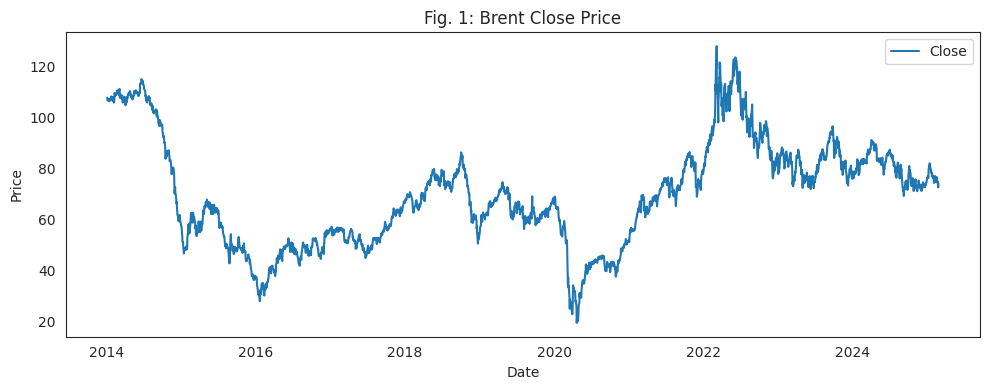

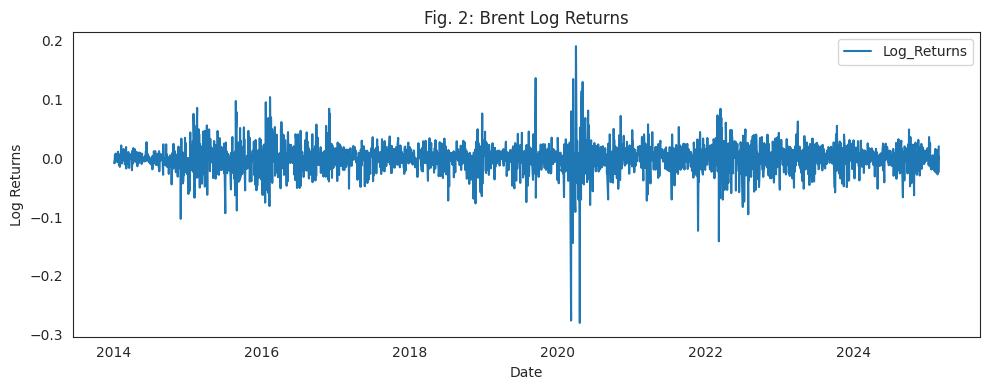

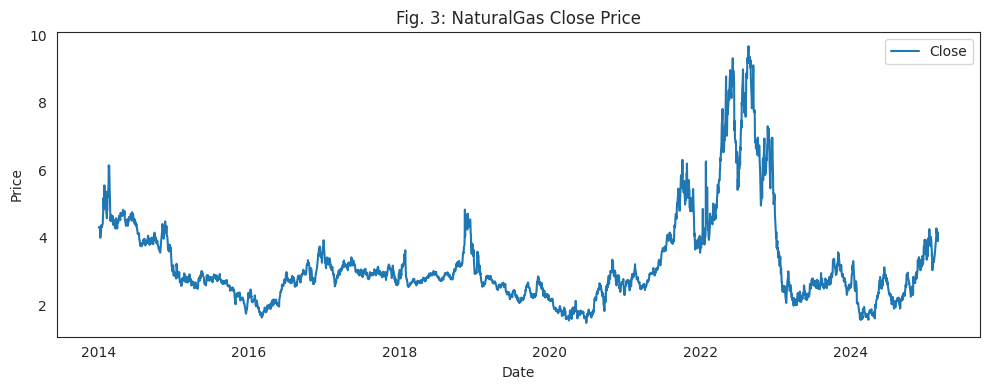

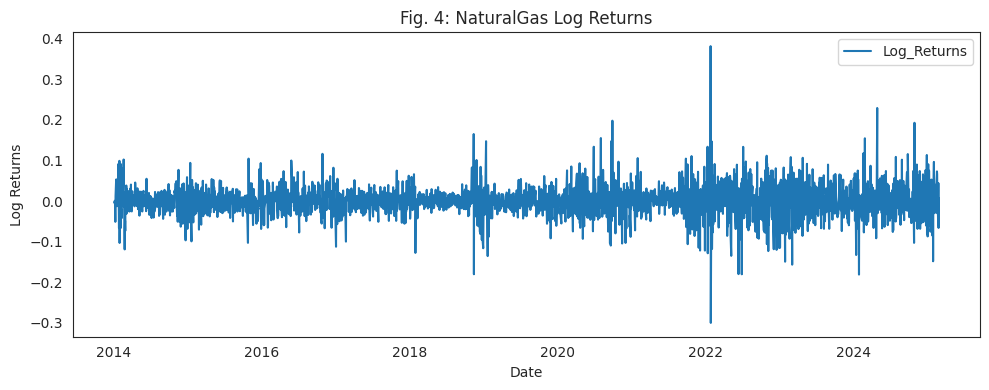

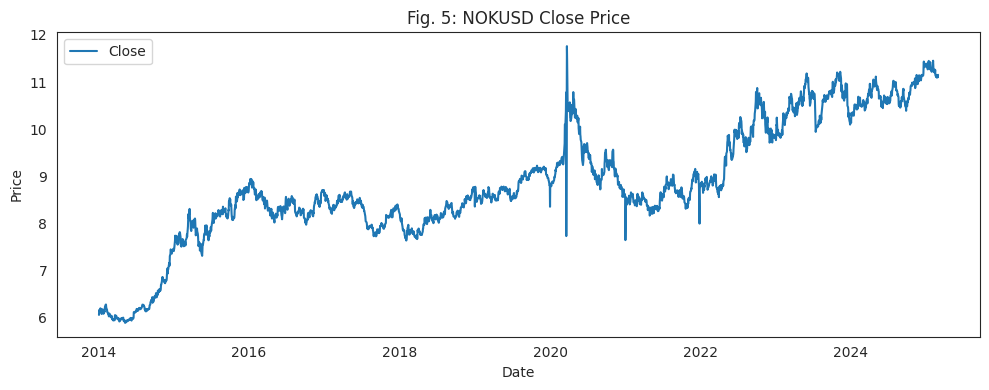

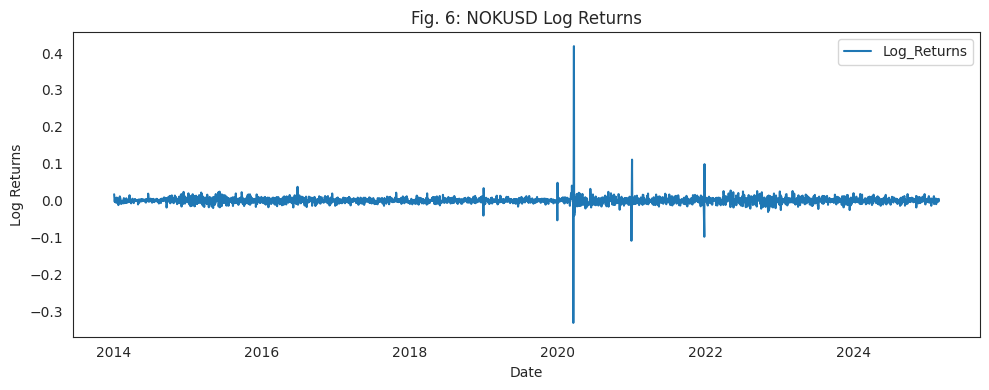

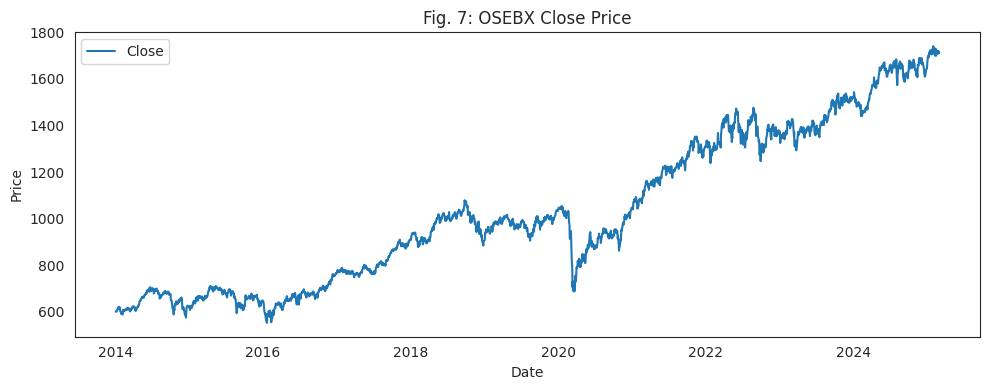

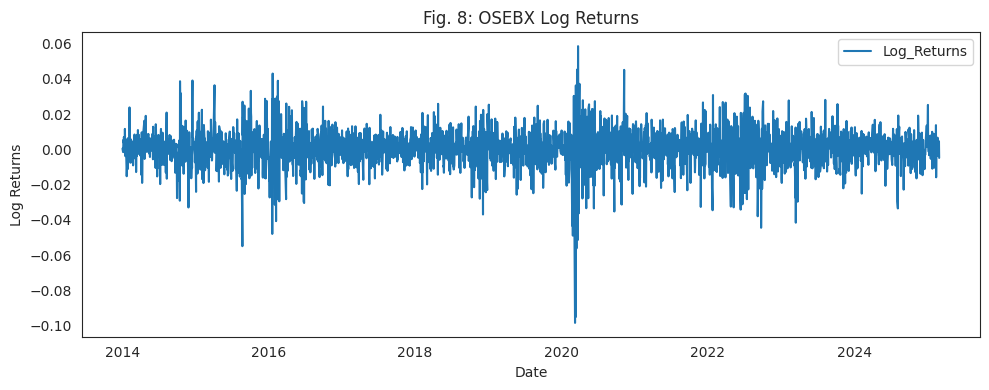

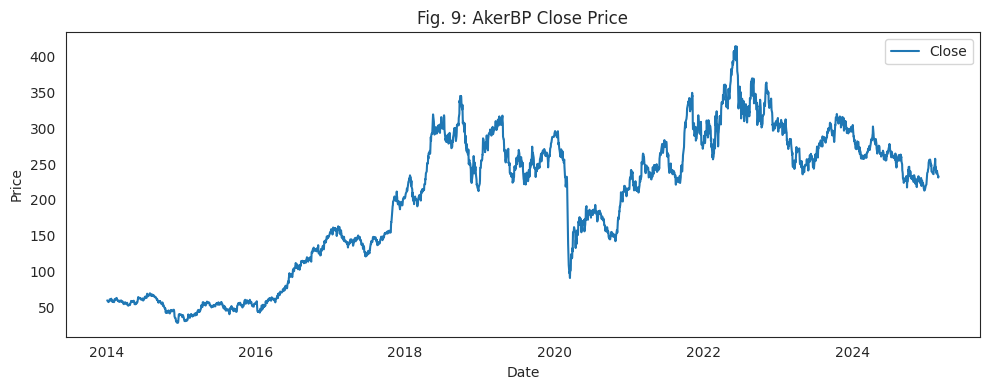

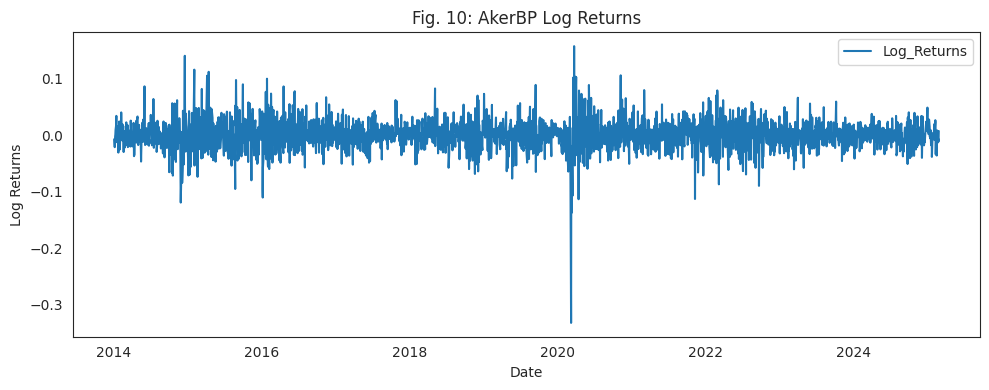

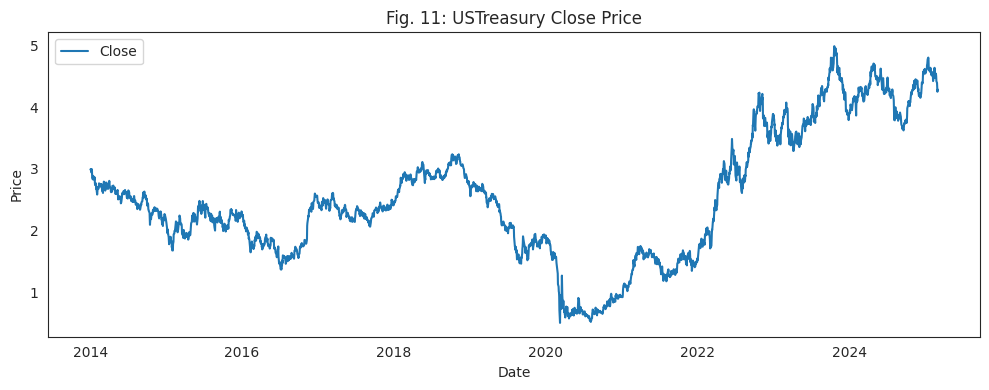

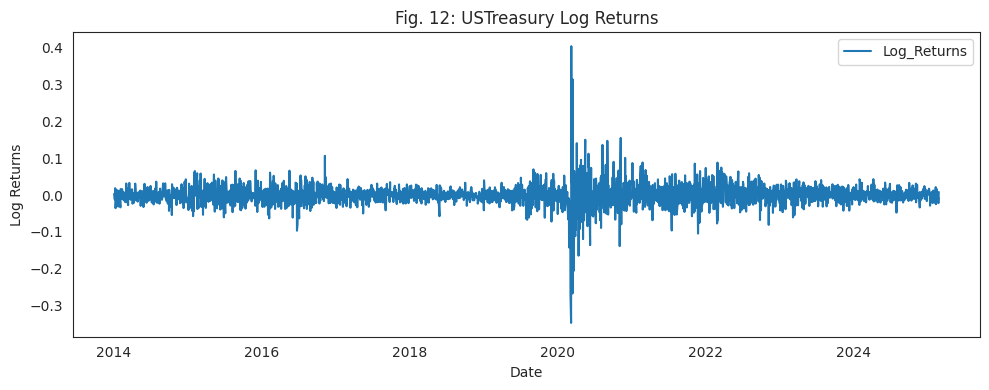

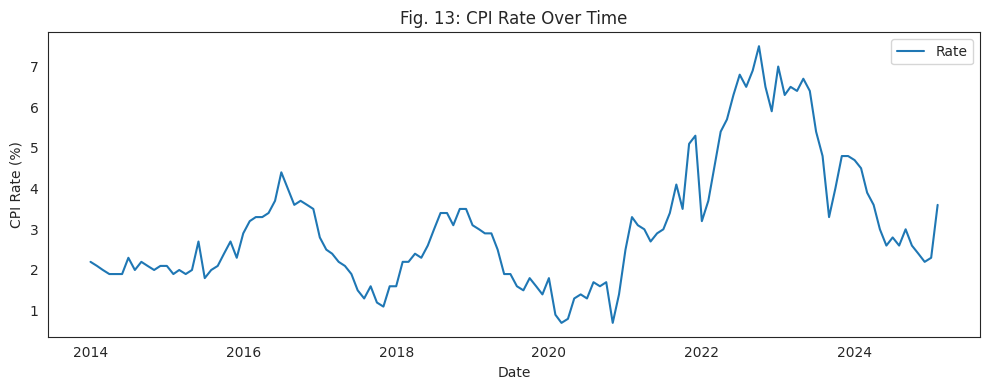

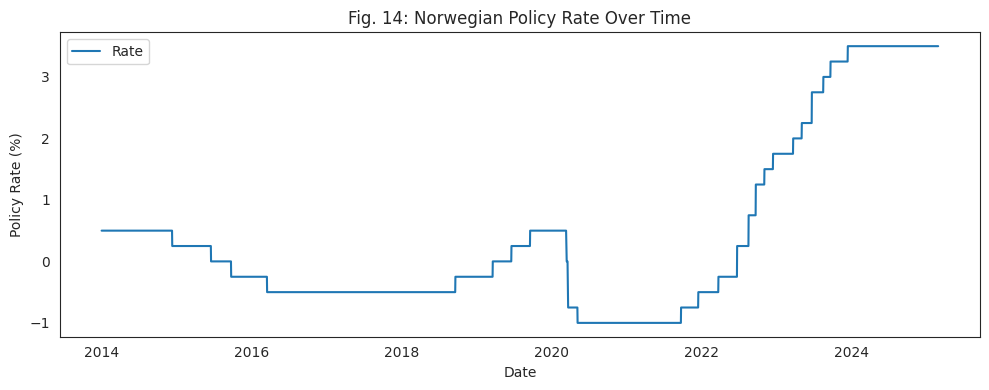

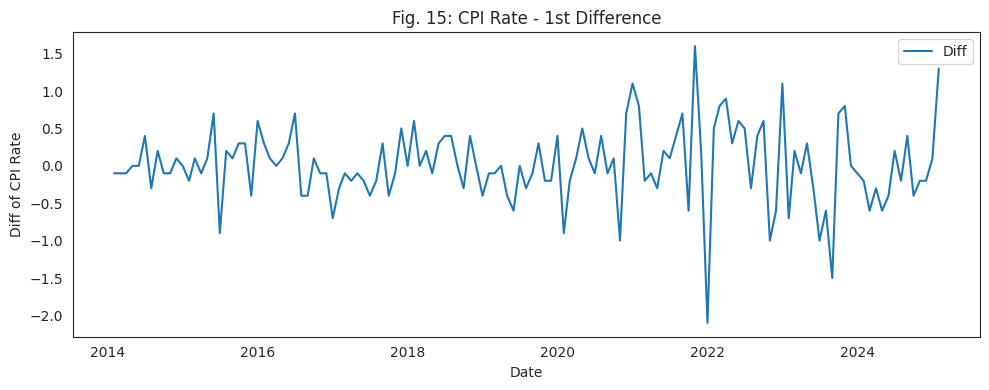

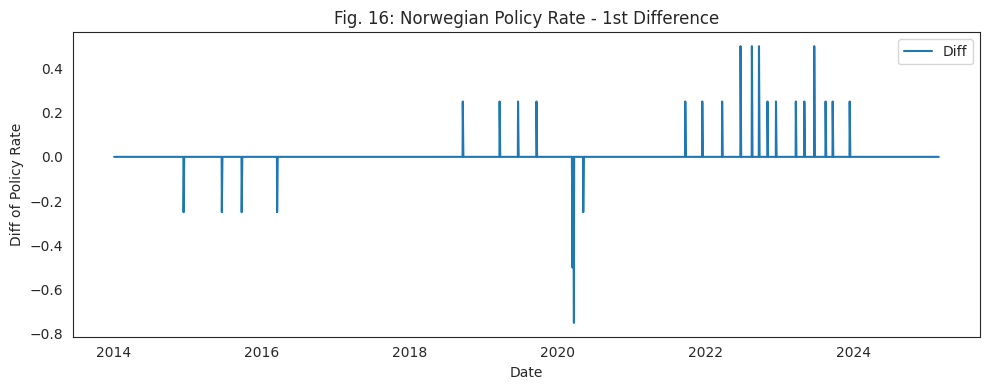

In [45]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

# Define directory and file names for daily data
data_dir = "financial_data"
file_names = {
    "Brent": "Brent_Crude.csv",
    "NaturalGas": "Natural_Gas.csv",
    "NOKUSD": "NOK_USD.csv",
    "OSEBX": "OSEBX.csv",
    "AkerBP": "Aker_BP.csv",
    "USTreasury": "US_10Yr_Treasury.csv"
}

# Load monthly datasets (CPI and Policy Rate)
cpi_df = pd.read_csv(os.path.join(data_dir, "CPI_Rate.csv"), parse_dates=["Date"])
policy_df = pd.read_csv(os.path.join(data_dir, "Norwegian_Policy_Rate.csv"), parse_dates=["Date"])

# Sort monthly data
cpi_df.sort_values("Date", inplace=True)
policy_df.sort_values("Date", inplace=True)

# Load the daily data into a dictionary of DataFrames
data_dict = {}
for key, file in file_names.items():
    file_path = os.path.join(data_dir, file)
    df = pd.read_csv(file_path, parse_dates=["Date"])
    df.sort_values("Date", inplace=True)
    data_dict[key] = df


# Visualisation of the data
# Function to plot a time series
def plot_series(df, date_col, value_col, title, ylabel, fig_num):
    plt.figure(figsize=(10, 4))
    plt.plot(df[date_col], df[value_col], label=value_col)
    plt.title(f"Fig. {fig_num}: {title}")
    plt.xlabel("Date")
    plt.ylabel(ylabel)
    plt.legend()
    plt.tight_layout()
    plt.show()
    print("\n")

# Visualize daily data: Plot both Close and Log Returns for each asset
fig_counter = 1
for key, df in data_dict.items():
    plot_series(df, "Date", "Close", f"{key} Close Price", "Price", fig_counter)
    fig_counter += 1
    plot_series(df, "Date", "Log_Returns", f"{key} Log Returns", "Log Returns", fig_counter)
    fig_counter += 1

# Visualize monthly data: CPI and Policy Rate (raw)
plot_series(cpi_df, "Date", "Rate", "CPI Rate Over Time", "CPI Rate (%)", fig_counter)
fig_counter += 1
plot_series(policy_df, "Date", "Rate", "Norwegian Policy Rate Over Time", "Policy Rate (%)", fig_counter)
fig_counter += 1

# Since CPI and Policy Rate are non-stationary, we difference them.
cpi_df["Diff"] = cpi_df["Rate"].diff()
policy_df["Diff"] = policy_df["Rate"].diff()

# Visualize the differenced (stationary) monthly data
plot_series(cpi_df, "Date", "Diff", "CPI Rate - 1st Difference", "Diff of CPI Rate", fig_counter)
fig_counter += 1
plot_series(policy_df, "Date", "Diff", "Norwegian Policy Rate - 1st Difference", "Diff of Policy Rate", fig_counter)
fig_counter += 1

##### Table 1: ADF Test Results

In [46]:
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import jarque_bera
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from statsmodels.api import add_constant
import statsmodels.api as sm

# Load the CSV files into DataFrames
df_aker_bp = pd.read_csv("financial_data/Aker_BP_weekly.csv")
df_brent_crude = pd.read_csv("financial_data/Brent_Crude_weekly.csv")
df_cpi_rate = pd.read_csv("financial_data/CPI_Rate_weekly.csv")
df_natural_gas = pd.read_csv("financial_data/Natural_Gas_weekly.csv")
df_nok_usd = pd.read_csv("financial_data/NOK_USD_weekly.csv")
df_norwegian_policy_rate = pd.read_csv("financial_data/Norwegian_Policy_Rate_weekly.csv")
df_osebx = pd.read_csv("financial_data/OSEBX_weekly.csv")
df_us_treasury = pd.read_csv("financial_data/US_10Yr_Treasury_weekly.csv")

# Rename the conflicting columns (columns with the same names)
df_aker_bp = df_aker_bp.rename(columns={'Log_Returns': 'Log_Returns_Aker_BP'})
df_brent_crude = df_brent_crude.rename(columns={'Log_Returns': 'Log_Returns_Brent_Crude'})
df_natural_gas = df_natural_gas.rename(columns={'Log_Returns': 'Log_Returns_Natural_Gas'})
df_nok_usd = df_nok_usd.rename(columns={'Log_Returns': 'Log_Returns_NOK_USD'})
df_osebx = df_osebx.rename(columns={'Log_Returns': 'Log_Returns_OSEBX'})
df_us_treasury = df_us_treasury.rename(columns={'Log_Returns': 'Log_Returns_US_Treasury'})
df_cpi_rate = df_cpi_rate.rename(columns={'Rate': 'CPI_Rate'})
df_norwegian_policy_rate = df_norwegian_policy_rate.rename(columns={'Rate': 'Policy_Rate'})

# Merge all the dataframes on 'Date'
df = df_aker_bp[['Date', 'Log_Returns_Aker_BP']]
df = pd.merge(df, df_brent_crude[['Date', 'Log_Returns_Brent_Crude']], on='Date', how='inner')
df = pd.merge(df, df_natural_gas[['Date', 'Log_Returns_Natural_Gas']], on='Date', how='inner')
df = pd.merge(df, df_nok_usd[['Date', 'Log_Returns_NOK_USD']], on='Date', how='inner')
df = pd.merge(df, df_osebx[['Date', 'Log_Returns_OSEBX']], on='Date', how='inner')
df = pd.merge(df, df_us_treasury[['Date', 'Log_Returns_US_Treasury']], on='Date', how='inner')
df = pd.merge(df, df_cpi_rate[['Date', 'CPI_Rate']], on='Date', how='inner')
df = pd.merge(df, df_norwegian_policy_rate[['Date', 'Policy_Rate']], on='Date', how='inner')

# Differencing the Policy Rate and CPI Rate to make them stationary
df['CPI_Rate_diff'] = df['CPI_Rate'].diff()
df['Policy_Rate_diff'] = df['Policy_Rate'].diff()

# Perform ADF test for each remaining variable and store results
results = []
df_numeric = df.drop('Date', axis=1)

for column in df_numeric.columns:
    adf_result = adfuller(df_numeric[column].dropna())
    p_value = adf_result[1]
    test_result = "Stationary" if p_value < 0.05 else "Non-stationary"

    results.append({
        'Variables': column,
        'Test Stat.':adf_result[0],
        'p-value': p_value,
        'Lags': adf_result[2],
        'Obs.': adf_result[3],
        'Results (95% Level)': test_result
    })

df = df.fillna(0)  # Replace NaN with 0
df.replace([float('inf'), -float('inf')], 1e10, inplace=True)  # Replace inf with 1e10

# Create a DataFrame from the results
results_df = pd.DataFrame(results)

# Display the table
print("Table 1: ADF Test Results\n")
print(results_df.to_markdown(index=False))

Table 1: ADF Test Results

| Variables               |   Test Stat. |     p-value |   Lags |   Obs. | Results (95% Level)   |
|:------------------------|-------------:|------------:|-------:|-------:|:----------------------|
| Log_Returns_Aker_BP     |   -10.4066   | 1.84967e-18 |      4 |    576 | Stationary            |
| Log_Returns_Brent_Crude |   -22.9454   | 0           |      0 |    580 | Stationary            |
| Log_Returns_Natural_Gas |   -24.545    | 0           |      0 |    580 | Stationary            |
| Log_Returns_NOK_USD     |    -8.14621  | 9.9732e-13  |     10 |    570 | Stationary            |
| Log_Returns_OSEBX       |   -12.3096   | 7.14057e-23 |      4 |    576 | Stationary            |
| Log_Returns_US_Treasury |   -10.2047   | 5.84491e-18 |      3 |    577 | Stationary            |
| CPI_Rate                |    -1.83766  | 0.361934    |     18 |    562 | Non-stationary        |
| Policy_Rate             |    -0.393659 | 0.911152    |     13 |    567 | Non-sta

## OLS Regression Model

After checking the stationarity of variables, we proceeded to construct an OLS regression model:
$$
\begin{align*}
r_{Aker}=&β_0+β_1r_{oil}+β_2r_{gas}+β_3r_{NOK}+β_4r_{OSEBX}+β_5r_{US10Y}+β_6Δ CPI+β_7ΔPolicy+ϵ \tag3 \\
r_{Aker} \text { : } &\text {weekly natural log return of Aker BP} \\
r_{oil} \text { : } &\text {weekly natural log return of Brent Crude Oil futures} \\
r_{gas} \text { : } &\text {weekly natural log return of natural gas futures} \\
r_{NOK} \text { : } &\text {weekly natural log return of NOK to USD FOREX} \\
r_{OSEBX} \text { : } &\text {weekly natural log return of OSEBX} \\
r_{US10Y} \text { : } &\text {weekly natural log return of US 10-Year Treasury yield} \\
ΔCPI \text { : } &\text {first difference of weekly CPI rate of Norway} \\
ΔPolicy \text { : } &\text {first difference of weekly Norges Bank policy rate} \\
ϵ \text { : } &\text {error term}
\end{align*}
$$
We aim to identify the key factors that significantly affect Aker BP's stock performance. These factors will then be used as variables in a subsequent SARIMAX model to forecast the company’s stock performance.

We expected a positive correlation between Brent Crude Oil and natural gas returns and the company's stock returns due to the company’s core operations. Similarly, we expected a positive correlation with the NOK/USD exchange rate, since an increase in this rate, indicating a weaker NOK, should result in higher nominal NOK revenue and likely push up the stock price. The OSEBX index is also expected to exhibit a positive correlation, reflecting broader market sentiment. Conversely, changes in US Treasury yields and policy rate differentials are expected to have a negative correlation, as rising rates increase discount rates, thereby lowering stock valuations. The effect of CPI rate differentials is less certain. While higher CPI may indicate increased petroleum prices, potentially boosting revenue, it could also increase costs and lead to lower profitability.

Table 2 shows the regression result. Overall, the the model explains approximately 56.6% of the variation in Aker BP's log returns, which is an acceptable result since there are tons of factors that can affect a company's stock performance. The F-stat also results in significance, suggesting at least one variable being used truely affect Aker BP's stock performance.

As for coefficients, among seven independent variables, only three of them are statistically significant: Brent crude oil return, OSEBX return, and U.S. 10-Year Treasury yields. As a result, these three factors are considered key factors and will be furthermore used in SARIMAX forecasting.

###### Table 2: OLS Regression Results

In [47]:
# Define the dependent variable (log returns of Aker BP's stock)
y = df['Log_Returns_Aker_BP']

# Define the independent variables
X = df[['Log_Returns_Brent_Crude', 'Log_Returns_Natural_Gas', 'Log_Returns_NOK_USD', 'Log_Returns_OSEBX', 'Log_Returns_US_Treasury', 'CPI_Rate_diff', 'Policy_Rate_diff']]

# Add a constant to the independent variables matrix (for the intercept in the regression)
X = sm.add_constant(X)

# Check for any NaN or Inf values in X before running the regression
if X.isnull().sum().any() or (X == float('inf')).sum().any():
    print("Warning: The X matrix contains NaN or infinite values. Cleaning data...")
    X = X.fillna(0)  # Replace NaN with 0 in the independent variables matrix
    X.replace([float('inf'), -float('inf')], 1e10, inplace=True)  # Replace inf with 1e10

# Run the regression
model = sm.OLS(y, X).fit()

# Print the regression results
print("Table 2: OLS Regression Results\n")
print(model.summary())

Table 2: OLS Regression Results

                             OLS Regression Results                            
Dep. Variable:     Log_Returns_Aker_BP   R-squared:                       0.566
Model:                             OLS   Adj. R-squared:                  0.561
Method:                  Least Squares   F-statistic:                     106.7
Date:                 Thu, 03 Apr 2025   Prob (F-statistic):           1.61e-99
Time:                         12:41:35   Log-Likelihood:                 1958.9
No. Observations:                  581   AIC:                            -3902.
Df Residuals:                      573   BIC:                            -3867.
Df Model:                            7                                         
Covariance Type:             nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------

### Diagnostics

After estimating the OLS model, we continue to perform diagnostic tests on the regression result as a rigorous approach.

#### Multicollinearity

Multicollinearity occurs when regressors are highly correlated to each other. This can result in distorted coefficient estimates, which make it difficult to determine the true effect of each variable. To test for multicollinearity in the, we calculate VIF for each regressor. Ideally, VIF should be close to 1, indicating minimal multicollinearity. An VIF above 5 suggest moderate multicollinearity while the one exceeding 10 could indicate a serious multicollinearity.

As shown in Table 3, all of the VIF are around 1, suggesting that our regressors do not exist of multicollinearity.

###### Table 3: VIF

In [48]:
# Check for multicollinearity: Calculate the VIF for each feature. 1 < VIF < 5 means low to moderate multicollinearity. VIF = 1 is ideal.
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print("Table 3: VIF")
print(vif_data)

Table 3: VIF
                   feature       VIF
0                    const  1.032314
1  Log_Returns_Brent_Crude  1.526448
2  Log_Returns_Natural_Gas  1.024411
3      Log_Returns_NOK_USD  1.063482
4        Log_Returns_OSEBX  1.567336
5  Log_Returns_US_Treasury  1.072346
6            CPI_Rate_diff  1.007872
7         Policy_Rate_diff  1.037489


#### Normally Distributed Residuals

Although normally distributed residuals is not one of the Gauss-Markov assumptions, it is important for conducting statistical inference. In particular, normality of residuals is necessary for making significance tests such as t-tests and F-tests.

There are two statistical tests for testing residuals' normality, the Omnibus test and the Jarque-Bera test. The Omnibus test examines the normality of residuals by combining skewness and kurtosis into a single statistic. Its null hypothesis is that residuals are normally distributed. The Jarque-Bera test evaluates the skewness and kurtosis of the sample and compares them to the skewness and kurtosis expected under a normal distribution. Its null hypothesis is that residuals are normally distributed as well.

The test statistics are shown in the regression result in Table 2. Both tests result in p-values lower than 0.05, suggesting our residuals are not normally distributed.

#### Heteroskedasticity

Heteroskedasticity refers to the variance of the residuals is not constant across regressors. If it occurs, it will violate the assumption of homoscedasticity and lead to inefficient estimates and biased inference tests. We used the Breusch-Pagan test to test for heteroskedasticity. The null hypothesis is that the variance of the residuals is constant.

The test returns with a p-value lower than 0.05, rejecting the null hypothesis, suggesting heteroskedasticity exists. Yet, we chose not to correct for it because our primary focus is on SARIMAX forecasting rather than on parameter inference. The performance of such forecasting model depends on its ability to capture the underlying time series patterns, and heteroskedasticity may affect standard error estimates but generally does not compromise the predictive accuracy of the SARIMAX model.

In [49]:
bp_test = het_breuschpagan(model.resid, model.model.exog)
print("Breusch–Pagan test p-value:", bp_test[1])

Breusch–Pagan test p-value: 1.414100584191187e-05


#### Autocorrelation

Autocorrelation refers to residuals of the regression model are correlated to their previous values, which violates the assumption of independence. The Durbin-Watson test is in used to check if autocorrelation exists. The test statistics ranges from 0 to 4. A value close to 2 suggests no autocorrelation, while below 2 indicates positive autocorrelation and above 2 indicates negative autocorrelation.

As shown in the regression result in Table 2, the DW test statistic returns as 1.945, which is close to 2, suggesting no serious autocorrelation exists.

#### Endogeneity

Endogeneity refers to regressors are correlated with the error term. This issue often arises due to omitted variables or measurement errors. The Durbin-Wu-Hausman test can test endogeneity in regression models. The null hypothesis is that there is no endogeneity.

We performed the test on NOK_USD since we suspected the series might be endogenous. The result, with a p-value lower than 0.05, confirmed our suspect, NOK_USD is indeed endogenous. Since we will not include NOK_USD in our SARIMAX model, its endogeneity does not impact our forecasting. Additionally, because we are only performing short-term forecasting, endogeneity is less of a concern.

In [50]:
# Check for endogeneity: Did the Durbin-Wu-Hausman test on NOK_USD. p < 0.05 means endogeneity is detected.
# Suspected endogenous variable and instrument
endogenous_var = 'Log_Returns_NOK_USD'
instrument_var = 'Log_Returns_US_Treasury'

# Ensure the instrument is not the dependent variable
exog_vars = [col for col in X.columns if col not in [endogenous_var, 'const']]
df['Instrument'] = df[instrument_var]

# Regress suspected endogenous variable on exogenous variables + instrument
first_stage = sm.OLS(df[endogenous_var], add_constant(df[exog_vars + ['Instrument']])).fit()
df['Residuals'] = first_stage.resid  # Get residuals

# Include residuals in original regression
second_stage = sm.OLS(y, add_constant(df[exog_vars + [endogenous_var, 'Residuals']])).fit()

# Durbin-Wu-Hausman test: Check significance of residuals
p_value = second_stage.pvalues['Residuals']

print(f"\nDurbin-Wu-Hausman Test for Exogeneity p-value {p_value}")


Durbin-Wu-Hausman Test for Exogeneity p-value 4.592234476504617e-05


#### Linearity

The last assumption needed to be tested is linearity. It ensures that the relationship between independent and dependent variables is appropriately modeled. We examined linearity by plotting residuals with fitted values. If no systematic patterns can be observed in the plot, the linearity assumption holds.

As shown in Fig. 17, there is a curved trend, suggesting that the model may not fully capture a linear relationship. However, since the OLS model is meant to help us identify key factors influencing the dependent variable rather than precisely modeling their correlations, this nonlinearity is not a major concern.

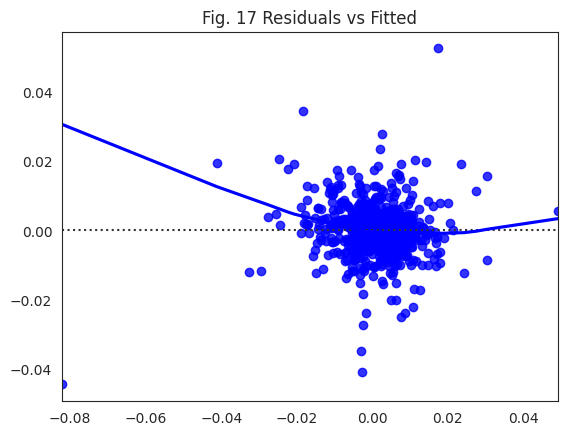

In [51]:
sns.residplot(x=model.fittedvalues, y=model.resid, lowess=True, color="b")
plt.title('Fig. 17 Residuals vs Fitted')
plt.show()

## SARIMAX Model

We have identified three key indicators from the previous OLS regression analysis: Brent crude oil return, OSEBX return, and U.S. 10-Year Treasury yields return. We then proceed with constructing the forecasting SARIMAX model.

SARIMAX model can be seen as an extended version of ARIMAX model. It incorporate seasonal components and external variables, which is a better approach toward our topic since oil operations are believed to have seaonsonal patterns and be affected by external factors. A SARIMAX model is usually defined with three parameters: number of autoregressive terms(p), the degree of differencing needed to make the time series stationary(d), and the number of moving average terms(q). The function we used is SARIMAX from statsmodels. According to the package document, the SARIMAX model is defined as:

(insert formula 4)

### Data Preparation

We first loaded the weekly return data from three key indicators we are going to use, forming them into one data frame. Moreover, we need to simulating the exogenous variables. Unlike OLS regression which we can feed the data to it, SARIMAX model depending on future values of the exogenous variables for prediction. We simulated the exogenous variables using ARIMA approach. It is worth to mention that simulations assumes a Geometric Brownian Motion was preferred, yet we decided to proceed with ARIMA results since it is not in scope of project.

The predicted results for three variables are shown in Fig. 18. One interesting thing is that we used different look back periods for three variables: 4 weeks for Brent crude oil return, 8 weeks for OSEBX return, and 16 weeks for US Treasury. The reason for these differnt periods is mainly because of their volatilities. With a highly volatile series, Brent oil in our case, the results tend to deviate to much and compromised the forecast model. Thus, we decided to use shorter look period for more volatile series and longer period for less volatile one.

Fig. 18 Predicted Exogenous Variables



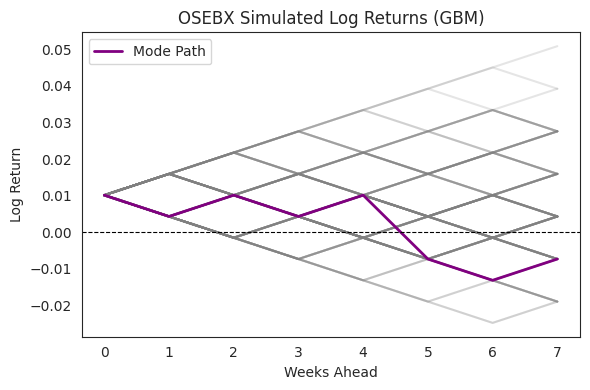

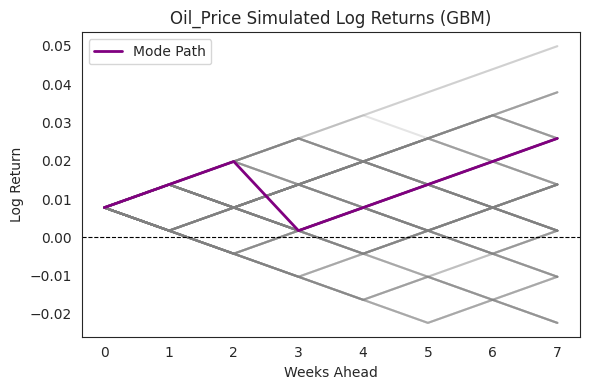

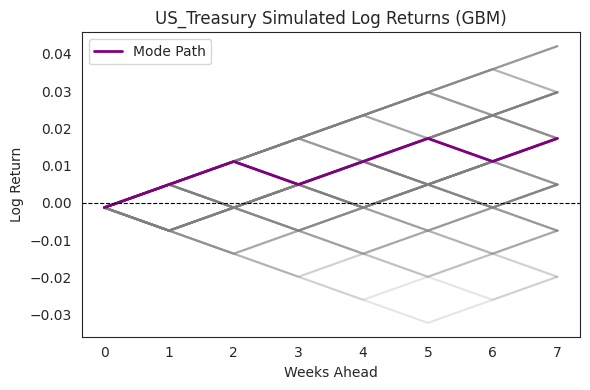

In [56]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, max_error
from scipy.stats import mode

data_path = "financial_data/" # The folder of the data

# Function to load weekly data and convert "YYYY-WW" format to datetime (Monday of the week)
def load_weekly_data(filename, value_col):
    df = pd.read_csv(data_path + filename)

    df['Date'] = pd.to_datetime(df['Date'] + '-1', format='%Y-%W-%w')   # Convert "YYYY-WW" format to datetime (Monday of each week)

    df.set_index('Date', inplace=True) # Set Date as index

    df = df[[value_col]] # Keep only the relevant column

    return df

# We define the different variables, using the function above. All are defined as weekly log returns
aker_bp_weekly = load_weekly_data("Aker_BP_weekly.csv", "Log_Returns")
oil_prices = load_weekly_data("Brent_Crude_weekly.csv", "Log_Returns")
osebx = load_weekly_data("OSEBX_weekly.csv", "Log_Returns")
us_treasury = load_weekly_data("US_10Yr_Treasury_weekly.csv", "Log_Returns")

merged_df = aker_bp_weekly.copy() # Merge datasets using outer join to retain all dates

# Dictionary of exogenous variables.
exogenous_vars = {
    "Oil_Price": oil_prices,
    "OSEBX": osebx,
    "US_Treasury": us_treasury
}

for var_name, df in exogenous_vars.items():
    df_renamed = df.rename(columns={df.columns[0]: var_name})
    merged_df = merged_df.merge(df_renamed, left_index=True, right_index=True, how='outer')


# Remove duplicate dates, if any
merged_df = merged_df[~merged_df.index.duplicated(keep='first')]

# Reindex to keep the original weekly timestamps
merged_df = merged_df.reindex(aker_bp_weekly.index)  # Ensure all dates match Aker BP weekly data

merged_df.rename(columns={"Log_Returns": "Aker_BP_Log_Returns"}, inplace=True)

# Fill missing values, to the nearest value
merged_df.ffill(inplace=True)
merged_df.bfill(inplace=True)

# # Check for no missing values
# print("\nMissing values after filling:")
# print(merged_df.isnull().sum())

# print(merged_df.head()) # Results show no missing values

# The data we use for simulation
datasets = {
    'OSEBX': osebx.copy(),
    'Oil_Price': oil_prices.copy(),
    'US_Treasury': us_treasury.copy()
}

target_date = pd.to_datetime('2024-12-31') # Simuation starting period, the same as the start of the testing period
n_steps = 8 # Simulate 8 weeks ahead, equivalent to the prediction period
n_simulations = 1000
dt = 1
lookback_for_p = 16  # We look 16 weeks back to find p_up for each exogeneous variables

# Different volatility of the variables makes different lookback periods necessarry
feature_settings = {
    'OSEBX': {'lookback_weeks': 8},
    'Oil_Price': {'lookback_weeks': 4}, # Oil price is volatile, hence the lookback period is shorter
    'US_Treasury': {'lookback_weeks': 16}
}

# Dictionary for storing simulated paths
mode_paths = {}

# Simulating paths for each exogeneous variable
for name, df in datasets.items():
    settings = feature_settings[name]
    lookback = settings['lookback_weeks']

    df.index = pd.to_datetime(df.index)
    df = df.sort_index()
    df = df[~df.index.duplicated(keep='first')]

    closest_idx = df.index.get_indexer([target_date], method='nearest')[0]  # Closest valid start date, in case missing
    closest_date = df.index[closest_idx]

    # Estimate volatility from recent returns
    returns_volatility = df.loc[closest_date - pd.DateOffset(weeks=lookback):closest_date]['Log_Returns']
    mu, sigma = returns_volatility.mean(), returns_volatility.std()
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u

    # Estimate p_up from 16 weeks of data
    returns_direction = df.loc[closest_date - pd.DateOffset(weeks=lookback_for_p):closest_date]['Log_Returns']
    p_up = (returns_direction > 0).mean()

    # Starting value
    start_value = df.iloc[closest_idx]['Log_Returns']

    # Simulate paths
    simulated = np.zeros((n_simulations, n_steps))
    for i in range(n_simulations):
        path = [start_value]
        for _ in range(1, n_steps):
            step = np.log(u) if np.random.rand() < p_up else np.log(d)
            path.append(path[-1] + step)
        simulated[i] = path

    # Mode path
    mode_path = mode(simulated, axis=0, keepdims=False)[0].flatten()
    mode_paths[name] = (mode_path, simulated)

# Plotting simulations of log returns of OSEBX, oil price and US Treasury bonds
print("Fig. 18 Predicted Exogenous Variables\n")

for name, (mode_path, simulated) in mode_paths.items():
    plt.figure(figsize=(6, 4))
    for i in range(100):
        plt.plot(range(n_steps), simulated[i], color='gray', alpha=0.2)
    plt.plot(range(n_steps), mode_path, color='purple', linewidth=2, label='Mode Path')
    plt.title(f'{name} Simulated Log Returns (GBM)')
    plt.xlabel('Weeks Ahead')
    plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
    plt.ylabel('Log Return')
    plt.legend()
    plt.tight_layout()
    plt.show()

### Fitting the ARIMAX Model

After predciting the exogenous variables as shown above, we fed these variables to ARIMAX model. Recall the model has three key parameters: p, d, and q., representing the number of autoregressive terms, the degree of differencing needed to make the time series stationary, and the number of moving average terms, respectively. Since we did not observe specific autocorrelations and lags, we decided to use parameter (1,1,1) to fit the model.

As shown in Table 4, the overall model fit well. Three regressors: oil prices, OSEBX, and US Treasury rates show significance. Moreover, the high log likelyhood and low AIC values both indicating the model presented a good fit. However, the AR term is insignificant, suggesting the lag one values can not predict future returns well. This could be a parameter that we could further optimize.

###### Table 4: SARIMAX Model

In [60]:
sns.set_style("white") # Defining style of plot

# We use the merged data of all the log returns
merged_df.index = pd.to_datetime(merged_df.index)
merged_df = merged_df[~merged_df.index.duplicated(keep='first')]
merged_df = merged_df.asfreq('W-MON')
merged_df.ffill(inplace=True) # Handle missing values
merged_df.bfill(inplace=True) # Handle missing values

train_end = pd.to_datetime('2024-12-31')
train_data = merged_df.loc[:train_end] # We train on data from start of dataset (2014) until this 2024-12-31
test_data = merged_df.loc[train_end:] # We predict/test on remainder of dataset

# We define the dependent and independent variables
Y_train = train_data['Aker_BP_Log_Returns']
X_train = train_data[['Oil_Price', 'OSEBX', 'US_Treasury']]


order = (1,1,1)
model = SARIMAX(Y_train, exog=X_train, order=order, enforce_stationarity=False, enforce_invertibility=False)
results = model.fit()

print("Table 4: SARIMAX Model\n")
print(results.summary())

Table 4: SARIMAX Model

                                SARIMAX Results                                
Dep. Variable:     Aker_BP_Log_Returns   No. Observations:                  574
Model:                SARIMAX(1, 1, 1)   Log Likelihood                1920.468
Date:                 Thu, 03 Apr 2025   AIC                          -3828.937
Time:                         12:58:03   BIC                          -3802.852
Sample:                     01-06-2014   HQIC                         -3818.760
                          - 12-30-2024                                         
Covariance Type:                   opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Oil_Price       0.3017      0.031      9.801      0.000       0.241       0.362
OSEBX           1.5657      0.060     26.236      0.000       1.449       1.683
US_Treasury    -

### Forecasting

With the SARIMAX model, we could now predict the future return on Aker BP. As mentioned earlier, since oil price is a relatively volatile series, we have decided that 8 weeks would be an optimal forecasting period. In Fig. 19, the blue line represent the historical values for fitting the model, the red line is the predicted values, and green line is the actual values. Fig.20 focus only on the prediction part. It shows that we could mostly predict the trend of the return. However, we still far away of predicting an accuracy return.

###### Fig. 19 ARIMAX Forecast with Simulated Exogenous Variables

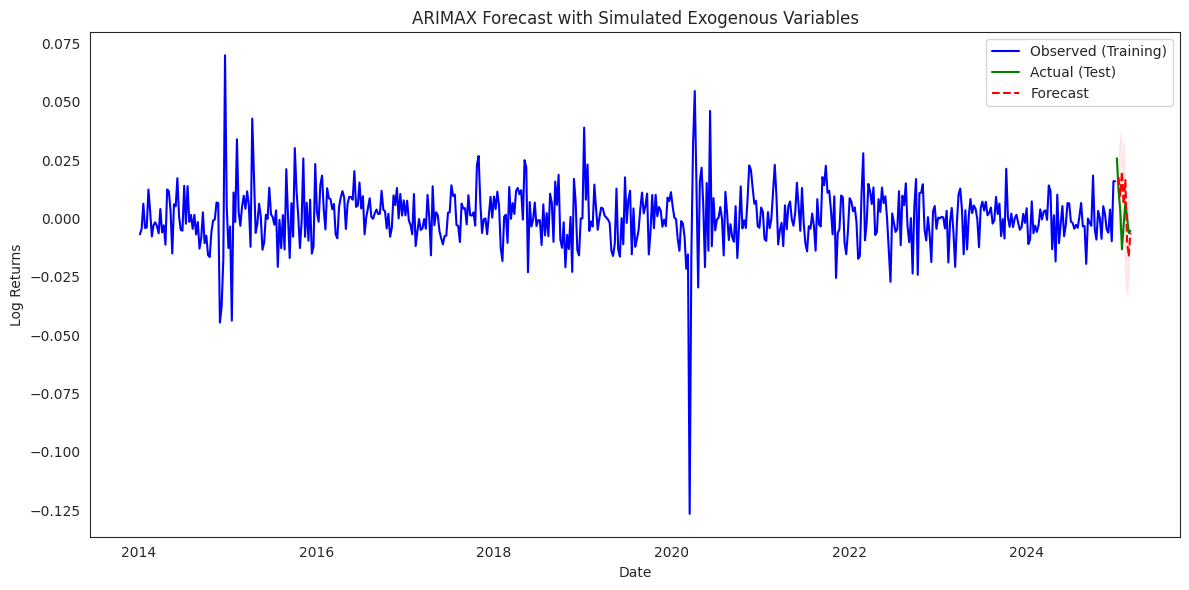

In [59]:
# We define the dates for forecasting
forecast_dates = pd.date_range(start=train_end + pd.Timedelta(weeks=1), periods=n_steps, freq='W-MON')

# We use the simulated values from step 2 in the prediction
simulated_exog = pd.DataFrame(index=forecast_dates)
for var in ['Oil_Price', 'OSEBX', 'US_Treasury']:
    simulated_exog[var] = mode_paths[var][0]  # mode path

# Initializing list for storing predicted values and confidence intervals
forecast_values, forecast_ci_lower, forecast_ci_upper = [], [], []

forecast = results.get_forecast(steps=n_steps, exog=simulated_exog)


forecast_df = pd.DataFrame({
    'Forecast': forecast.predicted_mean.values,
    'Lower CI': forecast.conf_int().iloc[:, 0],
    'Upper CI': forecast.conf_int().iloc[:, 1]
}, index=forecast_dates)

plt.figure(figsize=(12, 6))
sns.lineplot(x=train_data.index, y=train_data['Aker_BP_Log_Returns'], label='Observed (Training)', color='blue')
sns.lineplot(x=test_data.index, y=test_data['Aker_BP_Log_Returns'], label='Actual (Test)', color='green')
sns.lineplot(x=forecast_df.index, y=forecast_df['Forecast'], linestyle='dashed', color='red', label='Forecast')
plt.fill_between(forecast_df.index, forecast_df['Lower CI'], forecast_df['Upper CI'], color='pink', alpha=0.3)
plt.title('ARIMAX Forecast with Simulated Exogenous Variables')
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.legend()
plt.tight_layout()
plt.show()

###### Fig. 20 ARIMAX Forecast Only

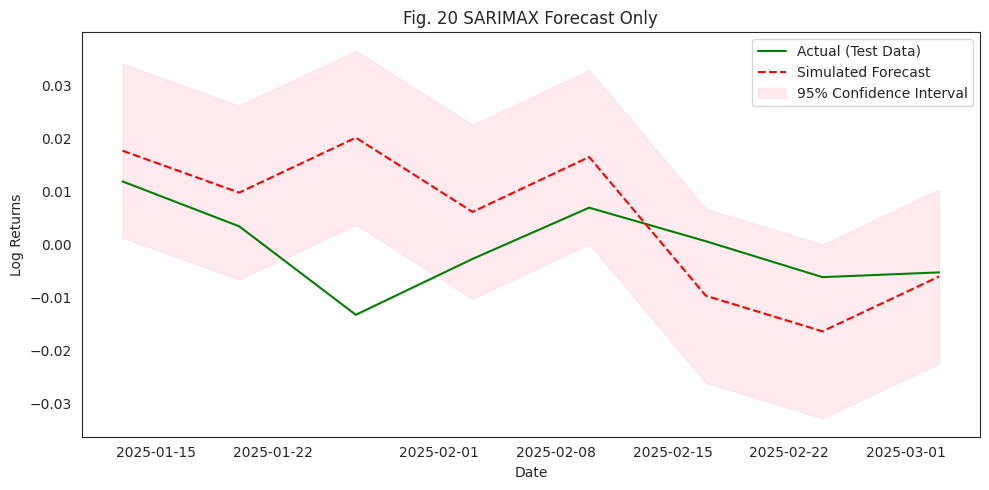

In [62]:
# Only the test period is plotted


# Rebuild forecast_df to ensure alignment
forecast = results.get_forecast(steps=n_steps, exog=simulated_exog)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Force correct datetime index
forecast_mean.index = forecast_dates
forecast_ci.index = forecast_dates

# Reassign forecast_df with proper alignment
forecast_df = pd.DataFrame({
    'Forecast': forecast_mean,
    'Lower CI': forecast_ci.iloc[:, 0],
    'Upper CI': forecast_ci.iloc[:, 1]
}, index=forecast_dates)

# Align actuals with forecast
actual_values = merged_df.reindex(forecast_df.index)['Aker_BP_Log_Returns']
valid_idx = actual_values.notna() & forecast_df['Forecast'].notna()
actual_values = actual_values[valid_idx]
forecast_series = forecast_df['Forecast'][valid_idx]

# --- Plot ---
plt.figure(figsize=(10, 5))

# Actual values
plt.plot(actual_values.index, actual_values.values, label='Actual (Test Data)', color='green')

# Forecast
plt.plot(forecast_df.index, forecast_df['Forecast'], linestyle='dashed', color='red', label='Simulated Forecast')

# Confidence Interval (aligned)
plt.fill_between(
    forecast_df.index,
    forecast_df['Lower CI'],
    forecast_df['Upper CI'],
    color='pink',
    alpha=0.3,
    label='95% Confidence Interval'
)

plt.title('Fig. 20 SARIMAX Forecast Only')
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.legend()
plt.tight_layout()
plt.show()